In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize

from nlpaug.util import Action
import nlpaug.augmenter.word as word_augmenter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Dropout, Flatten, Bidirectional, LSTM, GRU

import re
import string
from wordcloud import WordCloud
from collections import Counter

### Loading Dataset from CSV and save into data

In [2]:
data = pd.read_csv("SPAM text message 20170820 - Data.csv")
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Determing shape of dataframe

In [3]:
print("Shape of dataset: ", data.shape)

Shape of dataset:  (5572, 2)


### Finding the unique categories 

In [4]:
data['Category'].unique()

array(['ham', 'spam'], dtype=object)

### Cleaning up the data - Seeing if there are any missing values or null values

In [5]:
pd.DataFrame(data.isnull().sum(), columns=['Missing Values'])

,Missing Values
Category,0
Message,0


### Counting amount in each category and percentages

In [6]:
pd.DataFrame(data['Category'].value_counts())

,Category
ham,4825
spam,747


In [7]:
amountOfHam = data['Category'].value_counts()[0]
amountOfSpam = data['Category'].value_counts()[1]

hamPercentage = amountOfHam * 100 / data.shape[0]
spamPercentage = amountOfSpam * 100 / data.shape[0]

print("Percentage of ham: ", hamPercentage, "%")
print("Percentage of spam: ", spamPercentage, "%")

Percentage of ham:  86.59368269921033 %
Percentage of spam:  13.406317300789663 %


In [8]:
figure = px.pie(data, names = "Category", title= "Amount in each Category", hole = 0.5)

figure.update_traces(textposition = 'inside', textinfo = 'percent+label')

## Cleaning the data

In [9]:
STOPWORDS = stopwords.words('english')
punctuation = string.punctuation

### Removing URLS

In [10]:
def removeURLS(str):
    URL = re.compile(r'https?://\S+|www\.\S+')
    return URL.sub(r'', str)
data['Message'] = data['Message'].apply(removeURLS)

### Making everything lowercase

In [11]:
data['Message'] = data['Message'].str.lower()
data.head()

,Category,Message
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."


### Removing punctuation

In [12]:
def removePunctuation(str):
    formattedString = "".join([word for word in str if word not in punctuation])
    return formattedString
data['Message'] = data['Message'].apply(removePunctuation)

### Removing abundant whitespaces

In [13]:
def removeExtraWhiteSpaces(str):
    char_pattern = r'\s+[a-zA-Z]\s+'
    formattedString = re.sub(pattern = char_pattern, repl = " ", string = str)
    return formattedString
data['Message'] = data['Message'].apply(removeExtraWhiteSpaces)

### Removing Stopwords

In [14]:
def remove_stopwords(text):
    no_stopwords = []    
    tokens = word_tokenize(text)
    
    for i in range(len(tokens)):
        if tokens[i] not in STOPWORDS:
            no_stopwords.append(tokens[i])
            
    return " ".join(no_stopwords)
data['Message'] = data['Message'].apply(remove_stopwords)

### Lemmatization

In [15]:
def lemmatizeText(str):    
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(str)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)
data['Message'] = data['Message'].apply(lemmatizeText)

### Updating length of sentences

In [16]:
data['Message_Length'] = data['Message'].apply(len)
data.head()

,Category,Message,Message_Length
0,ham,go jurong point crazy available bugis great wo...,78
1,ham,ok lar joking wif oni,21
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,135
3,ham,u dun say early hor c already say,33
4,ham,nah dont think go usf life around though,40


## Most frequent words in SPAM data

In [17]:
spam_data = data[data['Category'] == 'spam']
spam_data = spam_data.reset_index().drop('index', axis = 1)

spam_counter = Counter()
for sent in spam_data['Message'].values:
    for word in sent.split():
        if word.lower() not in STOPWORDS:
            spam_counter[word] += 1

top_spam_words = pd.DataFrame(spam_counter.most_common(20), columns= ['Spam Words', 'Counts'])
top_spam_words.style.background_gradient()

,Spam Words,Counts
0,call,356
1,free,216
2,2,173
3,txt,150
4,ur,144
5,text,137
6,mobile,135
7,4,119
8,stop,115
9,claim,113


In [18]:
fig = px.histogram(top_spam_words,
                   x = 'Spam Words',
                   y = 'Counts', title="<b>Top 20 Spam Words in dataset</b>")

fig.update_layout(title_x = 0.5,
                  title_font = dict(size = 20))

fig.show()

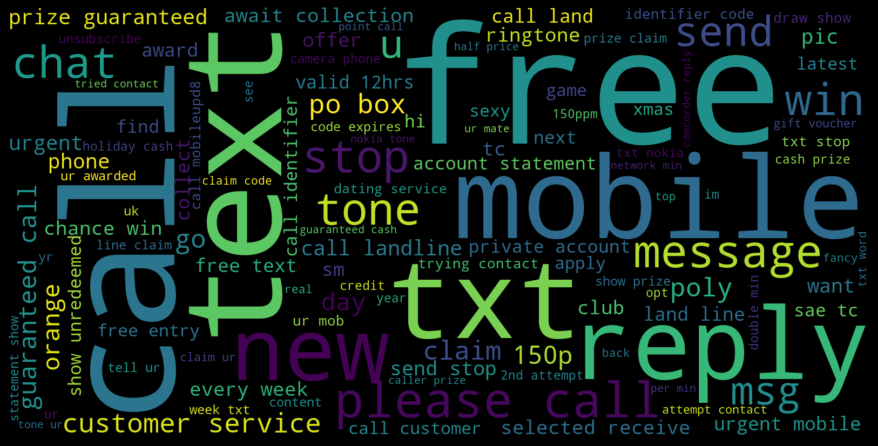

In [20]:
def displayWords(data, series):
    try:
        text = ' '.join(data[series])

        wordcloud = WordCloud(width = 1600 , height = 800, 
                              background_color ='black',                          
                              max_words=2000,
                              max_font_size=300,
                              min_font_size = 20).generate(text)

        plt.figure(figsize=(12, 8), facecolor = 'k', edgecolor = 'k' )
        plt.imshow(wordcloud, interpolation = 'bilinear')
        plt.axis("off")
        plt.tight_layout(pad = 0) 
        plt.show()
    
    except TypeError:
        print("Expected str instance")
displayWords(spam_data, "Message")

## Most frequent words in HAM data

In [21]:
ham_data = data[data['Category'] == 'ham']
ham_data = ham_data.reset_index().drop('index', axis = 1)

ham_counter = Counter()

for sent in ham_data['Message'].values:
    for word in sent.split():
        if word.lower() not in STOPWORDS:
            ham_counter[word] += 1

top_ham_words = pd.DataFrame(ham_counter.most_common(20), columns = ['Ham Words', 'Count'])
top_ham_words.style.background_gradient()

,Ham Words,Count
0,im,451
1,get,314
2,2,309
3,go,276
4,ltgt,276
5,ok,273
6,dont,265
7,ur,246
8,come,245
9,got,244


In [22]:
fig = px.histogram(top_ham_words,
                   x = 'Ham Words',
                   y = 'Count', title="<b>Top 20 Ham Words in dataset</b>")

fig.update_layout(title_x = 0.5,
                  title_font = dict(size = 20))


fig.show()

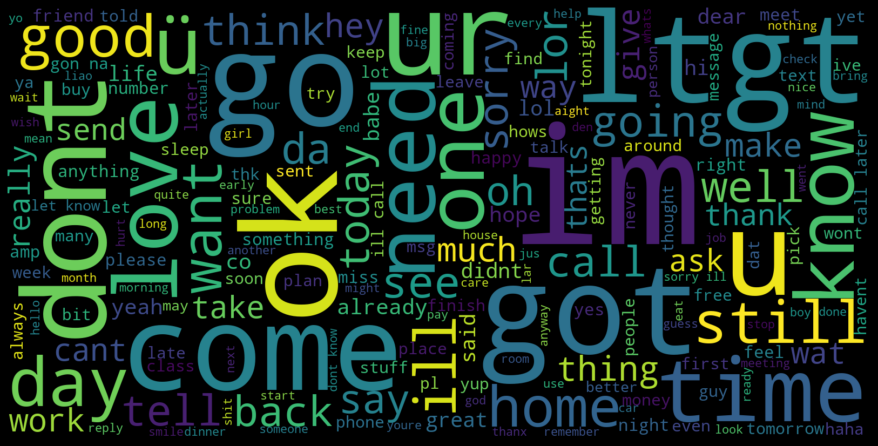

In [23]:
displayWords(ham_data, "Message")

## Balancing Dataset because the data is imbalanced. Using augmentation technique to artificially increase the amount of data by generating new data points from existing data

In [24]:
w_augmenter = word_augmenter.SynonymAug(aug_src='wordnet')

ITERATIONS = 5

# augment data 5 times
def augment_data(data, series, iterations):    
    aug_list = list()        
    
    try:        
        for i in range(iterations):
            for j in range(len(spam_data)):
                aug_text = w_augmenter.augment(data[series][j])
                aug_list.append(aug_text)

        return aug_list
    except:
        print("Error: Something went wrong")

aug_spam_list = augment_data(spam_data, "Message", ITERATIONS)
len(aug_spam_list)

3735

In [25]:
spam_data_aug = pd.DataFrame(aug_spam_list, columns=['Message'])
spam_data_aug.head()


,Message
0,loose entry 2 wkly comprehensive examination g...
1,freemsg hey darling 3 workweek word back id sa...
2,succeeder valued network client pick out recei...
3,mobile 11 month gas constant entitled update l...
4,six chance win cash 100 20000 british pound st...


In [26]:
spam_data_aug['Category'] = ['spam' for i in range(len(spam_data_aug))]

# Finding length of words in spam_data_aug
spam_data_aug['Message_Length'] = spam_data_aug['Message'].apply(len)

# Combining spam_data and spam_data_aug
spam_data = pd.concat([spam_data, spam_data_aug])
spam_data.head()


,Category,Message,Message_Length
0,spam,free entry 2 wkly comp win fa cup final tkts 2...,135
1,spam,freemsg hey darling 3 week word back id like f...,87
2,spam,winner valued network customer selected receiv...,120
3,spam,mobile 11 month r entitled update latest colou...,105
4,spam,six chance win cash 100 20000 pound txt csh11 ...,108


In [27]:
# Removing duplicates if any
spam_data.drop_duplicates(inplace=True)

# Combining ham_data and spam_data
data = pd.concat([ham_data, spam_data], axis=0)
data = data.reset_index().drop('index', axis=1)
data.head()

,Category,Message,Message_Length
0,ham,go jurong point crazy available bugis great wo...,78
1,ham,ok lar joking wif oni,21
2,ham,u dun say early hor c already say,33
3,ham,nah dont think go usf life around though,40
4,ham,even brother like speak treat like aid patent,45


### Finding count of each category - Data is now balanced

In [28]:
pd.DataFrame(data['Category'].value_counts())

,Category
ham,4825
spam,4277


In [31]:
fig = px.pie(data, names = "Category",
             title = "<b>Count in Category</b>",
             hole = 0.5)

fig.update_layout(title_x = 0.5,
                  title_font = dict(size = 20))

fig.update_traces(textposition='inside',
                  textinfo='percent+label')


fig.show()

## Labeling Categorical Feature

In [32]:
data['Category'] = data['Category'].map({"spam" : 1, "ham" : 0})
data.head()

,Category,Message,Message_Length
0,0,go jurong point crazy available bugis great wo...,78
1,0,ok lar joking wif oni,21
2,0,u dun say early hor c already say,33
3,0,nah dont think go usf life around though,40
4,0,even brother like speak treat like aid patent,45


## Tokenization

In [33]:
message = data['Message'].values
category = data['Category'].values

VOCAB_SIZE = 1000
MAX_LEN = data['Message_Length'].max()
EMBEDDING_VECTOR_SIZE = 6

# Turn words into numerical values
encoded_msg = [one_hot(msg, VOCAB_SIZE) for msg in message]

padded_message = pad_sequences(encoded_msg, maxlen=MAX_LEN, padding='post')
#print(padded_message)

X = padded_message
y = category

## Train, Test, Split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

## Creation of a neural network model

In [54]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBEDDING_VECTOR_SIZE, input_length = MAX_LEN, name='Embedding'))
model.add(Bidirectional(LSTM(40, return_sequences=True)))
model.add(Bidirectional(GRU(20)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [55]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 513, 6)            6000      
                                                                 
 bidirectional_6 (Bidirectio  (None, 513, 80)          15040     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 40)               12240     
 nal)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 40)                0         
                                                                 
 dropout_3 (Dropout)         (None, 40)                0         
                                                                 
 dense_15 (Dense)            (None, 8)                

In [56]:
model.compile(optimizer = 'adam',
loss = 'binary_crossentropy',
metrics = ['accuracy', 'binary_crossentropy'])

model1 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 10, batch_size=100)

Epoch 1/10
69/69 [==============================] - 53s 691ms/step - loss: 0.4926 - accuracy: 0.7301 - binary_crossentropy: 0.4926 - val_loss: 0.1867 - val_accuracy: 0.9301 - val_binary_crossentropy: 0.1867
Epoch 2/10
69/69 [==============================] - 50s 720ms/step - loss: 0.1299 - accuracy: 0.9559 - binary_crossentropy: 0.1299 - val_loss: 0.1070 - val_accuracy: 0.9649 - val_binary_crossentropy: 0.1070
Epoch 3/10
69/69 [==============================] - 52s 749ms/step - loss: 0.0737 - accuracy: 0.9767 - binary_crossentropy: 0.0737 - val_loss: 0.1002 - val_accuracy: 0.9710 - val_binary_crossentropy: 0.1002
Epoch 4/10
69/69 [==============================] - 51s 741ms/step - loss: 0.0508 - accuracy: 0.9851 - binary_crossentropy: 0.0508 - val_loss: 0.0974 - val_accuracy: 0.9728 - val_binary_crossentropy: 0.0974
Epoch 5/10
69/69 [==============================] - 52s 751ms/step - loss: 0.0358 - accuracy: 0.9919 - binary_crossentropy: 0.0358 - val_loss: 0.1101 - val_accuracy: 0.9666

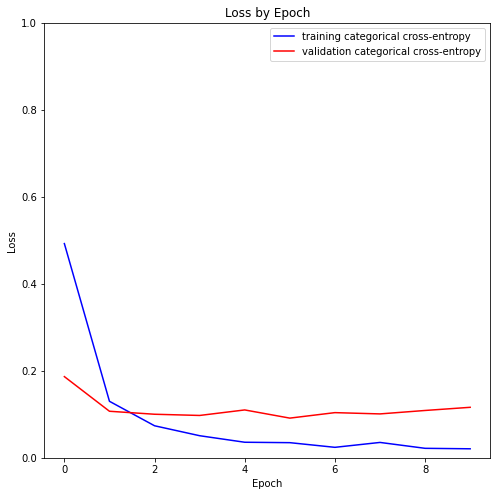

In [63]:
plt.figure(figsize=(8,8))
plt.plot(model1.history['loss'], label='training categorical cross-entropy', color='blue')
plt.plot(model1.history['val_loss'], label='validation categorical cross-entropy', color='red')
plt.title('Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1.])
plt.legend(loc='upper right')

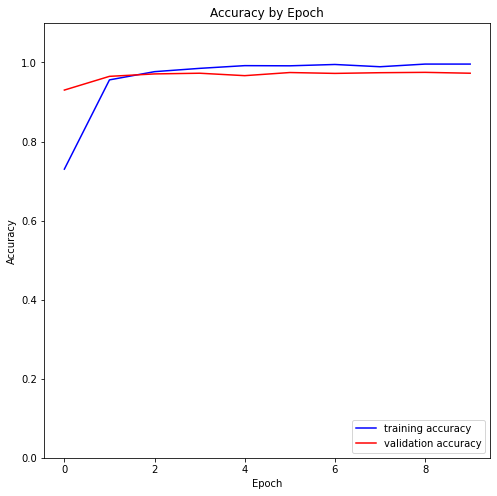

In [65]:
plt.figure(figsize=(8,8))
plt.plot(model1.history['accuracy'], label='training accuracy',color='blue')
plt.plot(model1.history['val_accuracy'], label = 'validation accuracy',color='red')
plt.title('Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')

In [1]:
train_acc = model1.history['accuracy']
train_loss = model1.history['loss']
val_loss = model1.history['val_loss']
val_acc = model1.history['val_accuracy']
epoch = [i + 1 for i in range(len(train_acc))]

acc_loss_data = pd.DataFrame({"Training Loss" : train_loss,
                            "Validation Loss": val_loss,
                            "Train Accuracy" : train_acc,
                            "Validation Accuracy" : val_acc,
                            "Epoch":epoch})

fig = go.Figure()

fig.add_trace(go.Scatter(x = acc_loss_data['Epoch'],
                         y = acc_loss_data['Train Accuracy'],
                         mode='lines+markers',
                         name='Training Accuracy'))

fig.add_trace(go.Scatter(x = acc_loss_data['Epoch'],
                         y = acc_loss_data['Validation Accuracy'],
                         mode='lines+markers',
                         name = 'Validation Accuracy'))

fig.update_layout(title = {'text': "<b>Training Accuracy Vs Validation Accuracy</b>\n",
                           'xanchor': 'center',
                           'yanchor': 'top',
                           'y':0.9,'x':0.5,},
                  xaxis_title="Epoch",
                  yaxis_title = "Accuracy",
                  title_font = dict(size = 20))

fig.layout.template = 'plotly_dark'

fig.show()

NameError: name 'model1' is not defined

In [50]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = acc_loss_data['Epoch'],
                         y = acc_loss_data['Training Loss'],
                         mode='lines+markers',
                         name='Training Loss'))

fig.add_trace(go.Scatter(x = acc_loss_data['Epoch'],
                         y = acc_loss_data['Validation Loss'],
                         mode='lines+markers',
                         name = 'Validation Loss'))

fig.update_layout(title = {'text': "<b>Training Loss Vs Validation Loss</b>\n",
                           'xanchor': 'center',
                           'yanchor': 'top',
                           'y':0.9,'x':0.5,},
                  xaxis_title="Epoch",
                  yaxis_title = "Loss",
                  title_font = dict(size = 20))

fig.layout.template = 'plotly_dark'

fig.show()

In [66]:
dct = model.evaluate(X_test, y_test)

accuracy = np.round(dct[1], 4) * 100
loss = np.round(dct[0], 4) * 100

print("Accuracy on unseen data: ", accuracy, "%")
print("Loss on unseen data: ", loss, "%")

72/72 [==============================] - 7s 94ms/step - loss: 0.1161 - accuracy: 0.9728 - binary_crossentropy: 0.1161
Accuracy on unseen data:  97.28 %
Loss on unseen data:  11.61 %


## Classification 

In [67]:
prediction = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, prediction, target_names= ['Ham', 'Spam']))

72/72 [==============================] - 6s 65ms/step
              precision    recall  f1-score   support

         Ham       0.97      0.98      0.97      1220
        Spam       0.98      0.96      0.97      1056

    accuracy                           0.97      2276
   macro avg       0.97      0.97      0.97      2276
weighted avg       0.97      0.97      0.97      2276



## Confusion Matrix

In [68]:
cm = confusion_matrix(y_test, prediction)
cm

array([[1200,   20],
       [  42, 1014]], dtype=int64)

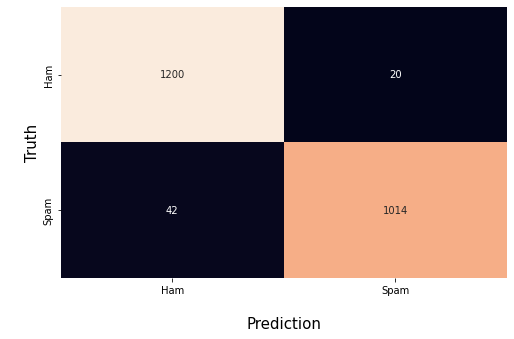

In [69]:
classes = ['Ham', 'Spam']

plt.figure(figsize = (8,5))
sns.heatmap(cm, annot = True, fmt = 'd', cbar=False).set(xticklabels = classes, yticklabels = classes)
plt.xlabel("\nPrediction", size = 15)
plt.ylabel("\nTruth",  size = 15)
plt.show()

## Model Prediction

In [70]:
def predict_category(text):
    text = removePunctuation(text)
    text = text.lower()
    
    encoded_text = [one_hot(text, VOCAB_SIZE)]
    padded_text = pad_sequences(encoded_text, maxlen=MAX_LEN, padding='post')
    
    pred = (model.predict(padded_text) > 0.5).astype("int32")
    pred = pred.flatten()[0]
    
    return "SPAM" if pred == 1 else "HAM"

In [77]:
text = "Get free car insurance and win a prize just call this number 0123456789"

category = predict_category(text)

print(f"Text is: {text}\n")
print(f"Category: {category}")

1/1 [==============================] - 0s 38ms/step
Text is: Get free car insurance and win a prize just call this number 0123456789

Category: SPAM


In [78]:
text = "WINNER!! As a valued customer, you have been selected to receive a $900 prize reward! Claim now before your offer expires!"

category = predict_category(text)

print(f"Text is: {text}\n")
print(f"Category: {category}")

1/1 [==============================] - 0s 42ms/step
Text is: WINNER!! As a valued customer, you have been selected to receive a $900 prize reward! Claim now before your offer expires!

Category: SPAM


In [79]:
text = "Hey! Nice seeing you this weekend. When will you be back in NYC"

category = predict_category(text)

print(f"Text is: {text}\n")
print(f"Category: {category}")

1/1 [==============================] - 0s 39ms/step
Text is: Hey! Nice seeing you this weekend. When will you be back in NYC

Category: HAM


In [80]:
text = "That cafe was so delicious! Make sure to send me $200 cash or vemno me for your part of the bill"

category = predict_category(text)

print(f"Text is: {text}\n")
print(f"Category: {category}")

1/1 [==============================] - 0s 41ms/step
Text is: That cafe was so delicious! Make sure to send me $200 cash or vemno me for your part of the bill

Category: SPAM
